### Data Load

In [1]:
import sqlite3
import os

URL = 'https://techassessment.blob.core.windows.net/aiap13-assessment-data/failure.db'

# If folder does not exist already, create the folder
if not os.path.isdir('data'):
    os.mkdir('data')

# Program will download the .db file from URL and paste into a relative path
db_file = 'data/failure.db'

import requests
with open(db_file, "wb") as f:
    f.write(requests.get(URL).content)

# Pipeline will read .db that is newly downloaded (at relative path)
conn = sqlite3.connect(db_file)

In [2]:
query_table_name = """SELECT name FROM sqlite_master  
  WHERE type='table';"""

cursor = conn.cursor()
cursor.execute(query_table_name)
print(cursor.fetchall())

[('failure',)]


There is only 1 table, so we will set the data into a single dataframe.

In [3]:
import pandas as pd

query_data = """SELECT * FROM failure;"""
df = pd.read_sql_query(query_data, conn)

### Preliminary metadata information 

Check for duplicates. Car ID is the unique ID. So we can remove any rows that have duplicate Car IDs.

In [4]:
dup = df[df.duplicated()]

print("Duplicate Rows :", len(dup))
pd.concat([dup.head(2), dup.tail(4)])

Duplicate Rows : 81


,Car ID,Model,Color,Temperature,RPM,Factory,Usage,Fuel consumption,Membership,Failure A,Failure B,Failure C,Failure D,Failure E
10000,fb6b1d49-ed23-42f2-8e39-292e568f517d,"Model 7, 2019",White,110.6 °C,1375,"Shang Hai, China",High,753.5,Normal,0,0,0,0,0
10001,db6a8f01-558c-4e77-b37a-0ba3a5e7bcb6,"Model 3, 2019",White,110.6 °C,1450,"Shang Hai, China",High,649.7,Normal,0,0,0,0,0
10077,246aa846-094d-441a-814a-ecf64d4e3775,"Model 5, 2020",White,110.6 °C,1750,"Berlin, Germany",Low,698.9,Premium,0,0,0,0,0
10078,0b9c5542-e343-4b7e-a4c9-aad358dbe993,"Model 3, 2019",White,110.6 °C,1529,"Shang Hai, China",Low,651.5,Normal,0,0,0,0,0
10079,fd5ac6de-3afb-4ad8-b4a9-4bc47b34dd08,"Model 3, 2019",Blue,110.6 °C,1523,"Berlin, Germany",High,638.8,Premium,0,0,0,0,0
10080,9df4c3f9-efdc-4fa2-bde4-b21d09b936cc,"Model 3, 2019",White,110.6 °C,1852,"Shang Hai, China",High,603.8,Premium,0,0,0,0,0


It appears that the final 81 rows are all duplicates. Remove them (otherwise graphs & models will be skewed).

In [5]:
df = df.drop_duplicates()
print (df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Car ID            10000 non-null  object 
 1   Model             10000 non-null  object 
 2   Color             10000 non-null  object 
 3   Temperature       10000 non-null  object 
 4   RPM               10000 non-null  int64  
 5   Factory           10000 non-null  object 
 6   Usage             10000 non-null  object 
 7   Fuel consumption  10000 non-null  float64
 8   Membership        9617 non-null   object 
 9   Failure A         10000 non-null  int64  
 10  Failure B         10000 non-null  int64  
 11  Failure C         10000 non-null  int64  
 12  Failure D         10000 non-null  int64  
 13  Failure E         10000 non-null  int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 1.1+ MB
None


- The dataframe has 10081 rows, which will be split into various validation, testing sets.
- There are 14 columns, where 5 are the target (failure) measurements. Set this to 'target' variable.
- 'Membership' has missing cells (null) - rows will undergo data imputing. Details in pipeline script.

In [6]:
# Print some data from the top and some from the tail end
print (pd.concat([df.head(3), df.tail(2)]))
target = ['Failure A', 'Failure B', 'Failure C', 'Failure D', 'Failure E']

                                    Car ID          Model  Color Temperature  \
0     137b948a-c99f-4afa-a2a7-9ef65ae51e8f  Model 5, 2022   Blue    110.3 °C   
1     3395a182-7e76-4fb3-94ba-5163d8f4e6b0  Model 3, 2022  Black    110.4 °C   
2     8c6a8e5b-d869-4665-b739-819c9e4a2070  Model 3, 2022   Grey    110.3 °C   
9998  d1f669dc-6fe2-4a0d-b5a9-26d3c6ab2c59  Model 7, 2021  White    231.1 °F   
9999  8aa49bd0-e297-4e6d-a031-72ea40325e75  Model 5, 2020   Grey    110.6 °C   

       RPM           Factory   Usage  Fuel consumption Membership  Failure A  \
0     1551  Shang Hai, China  Medium             659.7     Normal          0   
1     1408  Shang Hai, China  Medium             705.3    Premium          1   
2     1498  Shang Hai, China     Low             670.7    Premium          0   
9998  1408     New York, U.S    High             837.0    Premium          0   
9999  1500  Shang Hai, China     Low             746.7     Normal          0   

      Failure B  Failure C  Failure D 

### <b> Feature Engineering </b>

A quick review examination of some rows:
- Model can be split into Model Number & Model Year.
    - Based on the pdf description, larger model number means higher specifications. This means that the column has ordering, and should be preserved as an integer column in pipeline.
    - Model year, being a date value, will also to be ordered (i.e. preserved as integer column) in pipeline.
- Temperature has a value and symbol - will extract the value to a continuous float column.
- Factory (Location) can be split into Factory and Country

In [7]:
print (df.Factory.value_counts('%'), '\n')
print (df.Color.value_counts('%'), '\n')
print (df.Usage.value_counts('%'), '\n')
print (df.Membership.value_counts('%'), '\n')

Shang Hai, China    0.5478
Berlin, Germany     0.2215
New York, U.S       0.2127
Seng Kang, China    0.0106
Newton, China       0.0044
Bedok, Germany      0.0030
Name: Factory, dtype: float64 

White    0.5568
Red      0.1159
Blue     0.1129
Grey     0.1086
Black    0.1058
Name: Color, dtype: float64 

High      0.3527
Medium    0.3335
Low       0.3138
Name: Usage, dtype: float64 

Normal     0.466154
Premium    0.355204
None       0.178642
Name: Membership, dtype: float64 



Some further examination of the categorical variables:
- Seng Kang, Newton and Bedok factories seem to be tagged to China & Germany. Effect on data is uncertain as this only impacts ~1% of the data

In [8]:
def feature_eng(df_input):    
    # Get model number and model year
    # For the model number, need to exclude the word 'Model' from each row to make it an integer column
    df1 = df_input.copy()
    df1[['Model_Num', 'Model_Year']] = df1['Model'].str.split(', ', expand = True)    
    df1['Model_Num'] = pd.Series(map(lambda car: int(car[-1]), df1['Model_Num']))
    df1['Model_Year'] = df1['Model_Year'].astype(int)
        
    # Get Temperature value and symbol
    df1[['Temperature', 'Temp_symbol']] = df1['Temperature'].str.split(' ', expand = True)
    df1['Temperature'] = df1['Temperature'].astype(float)
    
    # Get City & Country from Factory column
    df1[['Factory', 'Country']] = df1['Factory'].str.split(', ', expand = True)
    
    # Get sum of failures per car
    df1['Failures'] = df1[target].sum(axis = 1)    
    
    # Remove old columns after engineering new features (reduce correlation, which can cause overfitting)
    df1 = df1.drop(['Model'], axis = 1)
    
    return df1

data_check = feature_eng(df)
print (data_check.Temp_symbol.value_counts(), '\n')
print (data_check.Failures.value_counts(), '\n')

°C    7830
°F    2170
Name: Temp_symbol, dtype: int64 

0    8738
1    1262
Name: Failures, dtype: int64 



- Temperature has both °C and °F. Will convert °F to °C.
- There is also a maximum of only 1 Failure type per row. This means that the failure types are <b> mutually exclusive</b>, making this a multi-class Hence, for plotting purposes, instead of taking the sum, will combine them into A, B, C, D, E, and No Fault.

#### Review New Features

In [9]:
data_check.describe()

,Temperature,RPM,Fuel consumption,Failure A,Failure B,Failure C,Failure D,Failure E,Model_Num,Model_Year,Failures
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.00000,10000.000000
mean,139.700810,1470.970100,679.456990,0.025900,0.018500,0.031000,0.024400,0.02640,4.000600,2016.60630,0.126200
std,50.813614,486.047372,58.439696,0.158845,0.134757,0.173326,0.154295,0.16033,1.342602,3.20305,0.332091
min,110.000000,-2636.000000,598.500000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000,2009.00000,0.000000
25%,110.600000,1418.000000,638.875000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000,2014.00000,0.000000
50%,112.200000,1499.000000,668.500000,0.000000,0.000000,0.000000,0.000000,0.00000,3.000000,2017.00000,0.000000
75%,125.400000,1609.000000,704.200000,0.000000,0.000000,0.000000,0.000000,0.00000,5.000000,2019.00000,0.000000
max,278.200000,2886.000000,904.800000,1.000000,1.000000,1.000000,1.000000,1.00000,7.000000,2022.00000,1.000000


- There seems to be a Temperature data outlier much higher than mean. Will confirm this further for °C records.
- Most of the failures are Failure C, and the least to be Failure B. Most of the rows are No Faults (The mean for Failures = 0.126, which comes to approx 13% of the data). <br> ML pipeline has to account for this heavy skewness (via stratify).
- RPM has a very broad standard deviation (almost 1/3 of the mean). RPM is measuring Torque speed. The negative values imply that the direction is opposite, i.e. either: 
    - car is reversing before failure was detected, or, 
    - within 30 days, no fault was measured, and the maximum speed was obtained when car was reversing.
    - However, even without data issues, the large negative (reverse) values are skewing the data set. Will add a boolean column 'Reverse', that returns True if RPM < 0, and False otherwise

In [10]:
print (data_check[(data_check.Temp_symbol == "°C")].Temperature.describe())

count    7830.000000
mean      113.117139
std         4.707411
min       110.000000
25%       110.400000
50%       111.400000
75%       113.600000
max       230.700000
Name: Temperature, dtype: float64


### <b> Data Cleaning </b>

Further check on the temperature data outlier, specifically for °C. The value seems to jump from 75th percentile (125.4). 
<br> Let's see how many records are beyond 200°C.

In [11]:
data_check.loc[(data_check.Temperature > 200) & (data_check.Temp_symbol == "°C"), ['Temperature']]

,Temperature
4,230.7


Since there is only 1 record with Temperature > 200°C, we can be quite certain it is an outlier and can update the value to the median. 

In [12]:
def feature_cleaning(df_input):
    df1 = df_input.copy()
    # Temperature Conversion
    df1['Temperature'] = pd.Series(map(lambda temp, sym: temp if sym[-1] == "C"
                            else ( round((temp - 32)/1.8, 1) )
                            , df1['Temperature'], df1['Temp_symbol']))
    df1.loc[(df1.Temperature > 200) & (df1.Temp_symbol == "°C"), ['Temperature']] = round(df1.Temperature.median(), 1)
    
    # Get sum of failures per car
    df1['Failures'] = pd.Series(map(lambda A, B, C, D, E, total: "A" if A == 1
                            else ( "B" if B == 1
                            else ( "C" if C == 1
                            else ( "D" if D == 1
                            else ( "E" if E == 1
                            else ( "No Fault" ) )))),
                            df1['Failure A'], df1['Failure B'], df1['Failure C'], df1['Failure D'], 
                                      df1['Failure E'], df1['Failures']))
    
    # Edit the country values for factories in Singapore
    df1['Country'] = pd.Series(map(lambda city, country: 'Singapore' if city in ['Seng Kang', 'Newton', 'Bedok'] else country, df1['Factory'], df1['Country']))
    
    # Check RPM values. If RPM < 0, 'Reverse' returns True, otherwise returns False. This column checks whether maximum torque was measured in Reverse direction or not
    # Then, set invoke modulus function on RPM
    df1['Reverse'] = pd.Series(map(lambda RPM: 'Reverse' if RPM < 0 else 'Forward', df1['RPM']))
    df1['RPM'] = pd.Series(map(lambda RPM: abs(RPM), df1['RPM']))
    
    return df1
    
data_full = feature_cleaning(data_check)
print ('The average Fahrenheit records convert to approx.', 
       round(data_full.loc[data_full.Temp_symbol == "°F", 'Temperature'].mean(), 1), 
       'Celsius. \n')

print (data_full.Country.value_counts('%'), '\n')
print (data_full.RPM.describe(), '\n')
print (data_full.Reverse.value_counts('%'))
data_full = data_full.drop(['Temp_symbol'], axis = 1)

The average Fahrenheit records convert to approx. 113.1 Celsius. 

China        0.5478
Germany      0.2215
U.S          0.2127
Singapore    0.0180
Name: Country, dtype: float64 

count    10000.000000
mean      1538.776100
std        179.284096
min       1168.000000
25%       1423.000000
50%       1503.000000
75%       1612.000000
max       2886.000000
Name: RPM, dtype: float64 

Forward    0.978
Reverse    0.022
Name: Reverse, dtype: float64


- The °F convert to roughly the median (112.1°C) - verifying the conversion formula. Subsequently, 'Temp_symbol' column can be dropped. 
- Singapore factories comprise around 1.7% of the data.
- RPM standard deviation (std) is much smaller now, which is good as Reverse direction is only ~2.2% of the data and actually drove the RPM std to 400+. 

Let's proceed to the visualisations.

### <b> Data Visualisation </b>

#### Numerical Variables

We will start off with some boxplots for the numerical columns.

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

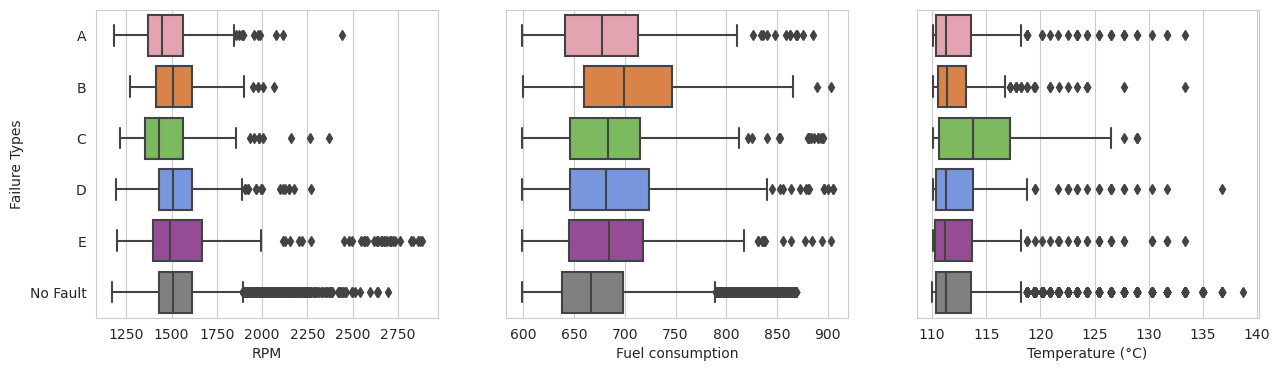

In [14]:
y_order = ['A', 'B', 'C', 'D', 'E', 'No Fault']
colour = ['#EE99AC', '#F08030', '#78C850', '#6890F0', '#A040A0', 'grey']
numerical = ['RPM', 'Fuel consumption', 'Temperature']
numerical_total = numerical + ['Reverse', 'Failures'] # Adding Failures to separate by colour
fig, axes = plt.subplots(1, len(numerical), figsize = (15, 4))

for each, axidx in zip(numerical, range(len(numerical))):
    sns.boxplot(data = data_full[numerical_total], x = each, y = 'Failures', order = y_order, palette = colour, ax=axes[axidx]);
    if axidx > 0:
        #sns.boxplot(data = data_full[numerical_total], x = each, y = 'Failures', order = y_order, palette = colour, ax=axes[axidx]);
        axes[axidx].set(ylabel="", yticklabels=[])
        
    else:
        #sns.boxplot(data = data_full[numerical_total], x = each, y = 'Reverse', hue = 'Failures', palette = colour, ax=axes[axidx]);
        #sns.boxplot(data = data_full[numerical_total], x = each, y = 'Reverse', order = 'Failures', palette = colour, ax=axes[axidx]);
        axes[axidx].set_ylabel('Max Torque');
        
axes[0].set_ylabel('Failure Types');
axes[2].set_xlabel('Temperature (°C)');

- RPM: B, D & E has similar median with No Fault (1500 RPM), while A & C have a lower median than them. E also has a greater variance due to the number of outliers (some cars reach >2750 RPM).
- Fuel Consumption: Generally, No Faults have lower Fuel consumption, median (675 L/km) & upper quartile (700 L/km). 
    - Failure B has the highest median & upp quart (750 L/km)
- Temperature: C has the largest median  upper quartile, comparatively C's median is approximately the upper quartile of the rest.

#### Correlation of the numerical variables

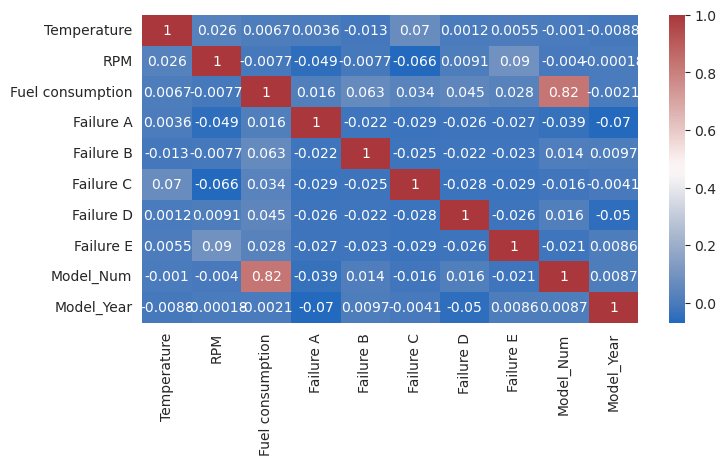

In [15]:
# Correlation of time and model number with the other variables
# calculate the correlation matrix
fig, ax = plt.subplots(figsize = (8, 4))
data_copy = data_full.copy()
#data_copy = data_copy.drop(['Model_Num'], axis = 1)
corr = data_copy.corr()

# plot the heatmap
sns.heatmap(corr, cmap = "vlag", annot = True,
        xticklabels=corr.columns, yticklabels=corr.columns);

Besides Model_Num and Fuel Consumption, correlation is quite small amongst the numerical variables.
- A: Strongest correlation is negative with Model Year at -0.07
- B: Strongest correlation is with Fuel Consumption at 0.063
- C: Strongest correlation is with Temperature at 0.07
- D: Strongest correlation is negative with Model Year at -0.07
- E: Strongest correlation is with RPM at 0.09

Let's examine the strong correlation between Model Num and fuel consumption further:

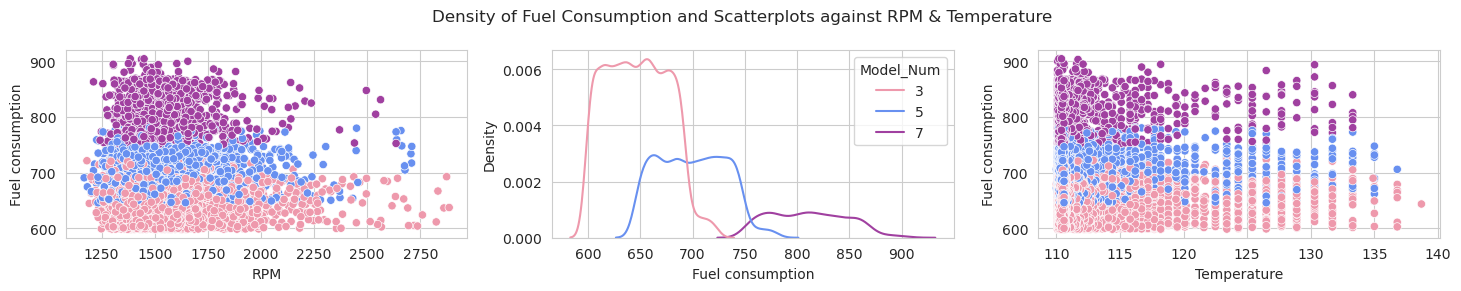

In [16]:
fig, axes = plt.subplots(1, len(numerical), figsize = (15, 3))
fig.tight_layout(pad = 3.0)
model_arr = numerical + ['Model_Num']
model_colour = ['#EE99AC', '#6890F0', '#A040A0']

plt.suptitle('Density of Fuel Consumption and Scatterplots against RPM & Temperature')

sns.scatterplot(data = data_full[model_arr], x = 'RPM', y = 'Fuel consumption', 
                hue = 'Model_Num', palette = model_colour, ax=axes[0], legend = False);
sns.kdeplot(data = data_full[model_arr], x = 'Fuel consumption', hue = 'Model_Num', 
            palette = model_colour, ax=axes[1]);
sns.scatterplot(data = data_full[model_arr], x = 'Temperature', y = 'Fuel consumption', 
                hue = 'Model_Num', palette = model_colour, ax=axes[2], legend = False);

- Model 3 is the most efficient model (least fuel consumption and lowest temperature)
- Most cars are model 3

#### Categorical Variables

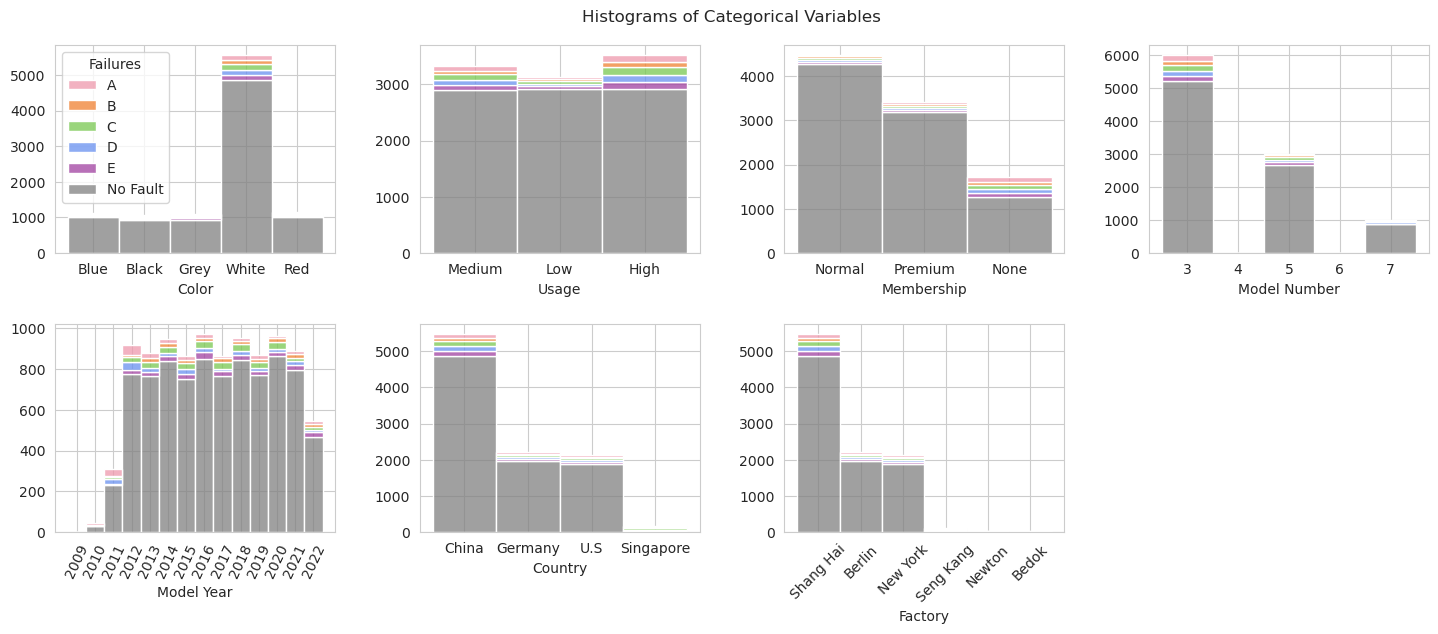

In [27]:
fig, axes = plt.subplots(2, 4, figsize = (15, 6))
fig.tight_layout(pad = 3.0)
plt.suptitle('Histograms of Categorical Variables')

categorical = ['Color', 'Usage', 'Membership', 'Model_Num', 'Model_Year', 'Country', 
               'Factory']
categorical_total = categorical + ['Failures']

for idx, ax_ in enumerate(axes.flat):
    chart = sns.histplot(data = data_full[categorical_total], x = categorical_total[idx], 
                         hue = 'Failures', hue_order = y_order, palette = colour, 
                     multiple = 'stack', ax=ax_, discrete = True);    
    
    chart.set(ylabel = None);
    if idx > 0:
        chart.get_legend().remove()
    
    if categorical_total[idx] == 'Factory':
        labels = ['Shang Hai', 'Berlin', 'New York', 'Seng Kang', 'Newton', 'Bedok']
        chart.set_xticks(labels, labels, rotation=45)
        
    elif categorical_total[idx] == 'Model_Year':
        labels = list(range(2009, 2023))
        chart.set_xticks(labels, labels, rotation=65)

# Update some X-Axis labels
axes[0][3].set(xlabel = 'Model Number')
axes[1][0].set(xlabel = 'Model Year')        

fig.delaxes(axes[1][3])

- Color: heavily skewed towards White car models
- Usage: Low car usage result in lower failures (which makes sense: if owner does not drive car often, there is a lower chance for car to fail)
- Membership: Smaller skew towards 'Normal', middle 'Premium', least 'None'
- 55% of the cars are manufactured in Shanghai, China
- Data available starts from 2009 to 2022, but 2009 and 2010 have very little data. 2022 only has roughly half of 2020 or 2021.

The No-Faults skew the count data, so the next charts will be stacked bars with only car failures.

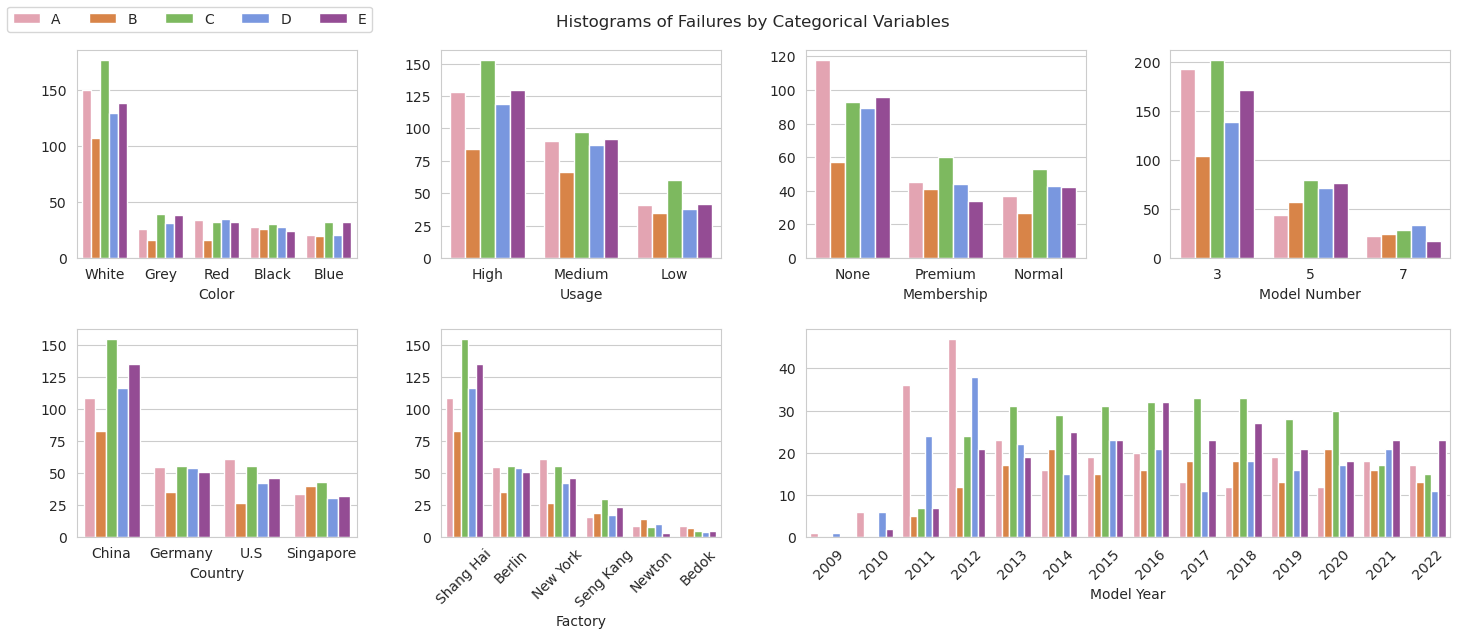

In [22]:
import matplotlib.ticker as mticker

fig, axes = plt.subplots(2, 4, figsize = (15, 6))
fig.tight_layout(pad = 3.0)
plt.suptitle('Histograms of Failures by Categorical Variables')

categorical = ['Color', 'Usage', 'Membership', 'Model_Num', 'Country', 'Factory', 'Model_Year']
categorical_total = categorical + ['Failures']
data_target = data_full.loc[data_full.Failures != 'No Fault', :]

# gridspec starts from 2nd row (1+1), 3rd column (2+1) subplot
gs = axes[1, 2].get_gridspec()
# remove the existing subplots
axes[1, 2].remove(); axes[1, 3].remove();

# replace the deleted subplots
# merge them into a horizontally long one (will use for Model_Year column which has 14 years)
# gs stretches on 2nd row (1+1) across the 3rd and 4th column subplots (2:)
axmerge = fig.add_subplot(gs[1, 2:])

for idx, ax_ in enumerate(axes.flat):
    orderx = list(data_target[categorical_total[idx]].value_counts().index)
    if categorical_total[idx] == 'Model_Year':        
        orderx = list(range(2009, 2023))
        ax_ = axmerge
    
    chart = sns.countplot(data = data_target[categorical_total], x = categorical_total[idx], hue = 'Failures', palette = colour[:-1], 
                     ax=ax_, order = orderx);
    ax_.set(ylabel = None);
    ax_.get_legend().remove()
    if categorical_total[idx] in ['Factory', 'Model_Year']:
        chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)        

# Update some X-Axis labels
axes[0][3].set(xlabel = 'Model Number')
axmerge.set(xlabel = 'Model Year')

# Add legend on figure level, to set it on top, ncol to make it horizontal
handles, labels = ax_.get_legend_handles_labels();
fig.legend(handles, labels, loc = 'upper left', ncol = 5);


#### Categorical Variables - Failures
- White cars have the largest number of failures (likely because most cars in dataset are White)
    - White cars are more likely to have A & C failures, while most Blue cars have either C or E failures
- Previous observation: Low car usage result in lower failures
    - Failure C is consistently the most common across all 3 usage types
- Membership: Non-member cars favour Failure A, while Premium & Normal members more commonly have failure C
- Model Number: Failure A occur less frequently in model 5 & 7. Similar pattern is observed in Failure E.
- Recall that China factories make up >50% of the cars in data set and they predominantly has failure C and E
    - Conversely, Germany & Singapore cars are more even in their distribution while US cars mainly has A, C & E failures
- Singapore Factories have a different distribution with country level, esp. Newton & Bedok. Will decide to use only Factory in MLP.
- Distribution of failures by Year:
    - 2010 to 2012: majority of the failures were A & D, tapering from 2013 onwards. In 2022, Failure D has become the least common failure.
    - 2013 to 2020: C has overtaken to be the most dominant failure type
    - 2016 to 2022: E spiked in 2016 and now the most dominant, while C tapered off post 2020.
    - Failure B has some spikes throughout, but comparatively has been lower than average.

In [19]:
# Close connection and remove the file from directory
import shutil
shutil.rmtree('data')

### <b> Key Takeaways </b>
#### Data Issues:
- Data has 81 duplicates
- Membership column has null values - require imputing
- Temperature - converted °F to °C, edited an outlier >200°C to median (~112.1°C)

### Features & Observations:
#### Numerical 
- RPM: reverse RPM, create 'Reverse' variable to account for negative Torque high values, then applied modulus function to turn all negative values to positive RPM 
- Model Number correspond very well to Fuel consumption - Model 3 is the most efficient (least fuel consumption & lowest temperature) and most cars in dataset are model 3
    - Failure A occur less frequently in model 5 & 7. Similarly for E.
- Distribution of failures by Year:
    - 2010 to 2012: majority of the failures were A & D, tapering from 2013 onwards. In 2022, Failure D has become the least common failure.
    - 2013 to 2020: C has overtaken to be the most dominant failure type
    - 2016 to 2022: E spiked in 2016 and now the most dominant, while C tapered off post 2020.
    - Failure B has some spikes throughout, but comparatively has been lower than average.
- A: Strongest correlation is negative with Model Year at -0.07
- B: Strongest correlation is with Fuel Consumption at 0.063
- C: Strongest correlation is with Temperature at 0.07
- D: Strongest correlation is negative with Model Year at -0.07
- E: Strongest correlation is with RPM at 0.09

#### Categorical
- Color: heavily skewed towards White car models
    - White cars are more likely to have A & C failures, while most Blue cars have either C or E failures
- Usage: Low car usage result in lower failures (which makes sense: if owner does not drive car often, there is a lower chance for car to fail)
    - Failure C is consistently the most common across all 3 usage types
- Membership: Smaller skew towards 'Normal', middle 'Premium', least 'None'
    - Non-member cars favour Failure A, while Premium & Normal members more commonly have failure C
- Factory: added Country variable. Factory level and Country seem very little difference, hence, pipeline will only use Country
    - 55% of the cars are manufactured in Shanghai, China. Mostly Failure C and E
    - Conversely, Germany & Singapore cars are more even in their distribution while US cars mainly has A, C & E failures